# Dual Pathway Independence Analysis

Complete analysis testing both dorsal and ventral pathway independence plus critical overlap analysis

"""
Independent Networks Overlap Analysis

Calculate dice coefficients between:
1. Original pIPS vs Original LO (should reproduce 91.4%)
2. Independent pIPS_clean vs Independent LO_clean (new result)

This uses the exact same methodology as the successful clean overlap analysis,
applying it to both original and independent network pairs.
"""

In [13]:
import os
import numpy as np
import pandas as pd
import nibabel as nib
from nilearn import image, plotting, datasets
from nilearn.input_data import NiftiMasker
from nilearn.glm import threshold_stats_img
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print("Libraries loaded successfully!")
print(f"Analysis started: {datetime.now()}")

/home/csimmon2/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


Libraries loaded successfully!
Analysis started: 2025-09-19 15:42:56.439847


In [7]:
# Cell 2: Define directories and parameters
study_dir = "/lab_data/behrmannlab/vlad/ptoc"
residual_dir = "/user_data/csimmon2/ptoc_residuals"
results_dir = "/user_data/csimmon2/git_repos/ptoc/results"
curr_dir = "/user_data/csimmon2/git_repos/ptoc"

# Parameters
alpha = 0.05
cluster_threshold = 5
hemispheres = ['left', 'right']

# Load subjects
sub_info = pd.read_csv(f'{curr_dir}/sub_info.csv')
subjects = sub_info[sub_info['group'] == 'control']['sub'].tolist()

print(f"Subjects: {len(subjects)}")
print(f"Parameters: FDR α={alpha}, cluster>{cluster_threshold}")

Subjects: 19
Parameters: FDR α=0.05, cluster>5


In [12]:
# Cell 3: Helper functions
def load_subject_maps(subjects, analysis_type, roi, hemisphere, task='loc'):
    all_imgs = []
    valid_subjects = []
    
    for sub in subjects:
        if analysis_type == 'original':
            filepath = f"{study_dir}/{sub}/ses-01/derivatives/fc_mni/{sub}_{roi}_{hemisphere}_{task}_fc_mni.nii.gz"
        elif analysis_type == 'dorsal_cleaned':
            filepath = f"{residual_dir}/{sub}/ses-01/derivatives/fc_mni/{sub}_pIPS_clean_{hemisphere}_{task}_fc_mni.nii.gz"
        elif analysis_type == 'ventral_cleaned':
            filepath = f"{residual_dir}/{sub}/ses-01/derivatives/fc_mni/{sub}_LO_clean_{hemisphere}_{task}_fc_mni.nii.gz"
        
        if os.path.exists(filepath):
            all_imgs.append(nib.load(filepath))
            valid_subjects.append(sub)
        else:
            print(f"Missing: {os.path.basename(filepath)} for {sub}")
    
    return all_imgs, valid_subjects

def apply_threshold(mean_img, label):
    from nilearn import image  # Import here to avoid namespace issues
    zstat_img = image.math_img("(img-img.mean())/img.std()", img=mean_img)
    thresh_result = threshold_stats_img(zstat_img, alpha=alpha, height_control='fdr', 
                                       cluster_threshold=cluster_threshold, two_sided=False)
    thresh_img, thresh_val = thresh_result[0], thresh_result[1]
    
    data = thresh_img.get_fdata()
    data[data <= 0] = 0
    final_img = nib.Nifti1Image(data.astype('double'), mean_img.affine)
    
    print(f"  {label} threshold: {thresh_val:.3f}")
    return final_img, thresh_val

def compute_dice(img1, img2):
    data1 = (img1.get_fdata() > 0).astype(int)
    data2 = (img2.get_fdata() > 0).astype(int)
    intersection = np.sum(data1 * data2)
    total_voxels = np.sum(data1) + np.sum(data2)
    return 2.0 * intersection / total_voxels if total_voxels > 0 else 0

print("Helper functions ready!")

Helper functions ready!


In [13]:
# Cell 4: Load and process network data
print("Loading network data...")

# Load original pIPS and LO networks (hemisphere-specific)
orig_pips_imgs = {}
orig_lo_imgs = {}
clean_pips_imgs = {}
clean_lo_imgs = {}

valid_subjects = []

for hemi in hemispheres:
    print(f"\nProcessing {hemi} hemisphere...")
    
    # Original networks
    pips_imgs, pips_subs = load_subject_maps(subjects, 'original', 'pIPS', hemi)
    lo_imgs, lo_subs = load_subject_maps(subjects, 'original', 'LO', hemi)
    
    # Cleaned networks
    clean_pips_imgs_hemi, clean_pips_subs = load_subject_maps(subjects, 'dorsal_cleaned', 'pIPS', hemi)
    clean_lo_imgs_hemi, clean_lo_subs = load_subject_maps(subjects, 'ventral_cleaned', 'LO', hemi)
    
    # Find common subjects across all conditions
    common_subs = list(set(pips_subs) & set(lo_subs) & set(clean_pips_subs) & set(clean_lo_subs))
    if 'sub-084' in common_subs:
        common_subs.remove('sub-084')
    
    print(f"  Common subjects for {hemi}: {len(common_subs)}")
    
    orig_pips_imgs[hemi] = pips_imgs
    orig_lo_imgs[hemi] = lo_imgs
    clean_pips_imgs[hemi] = clean_pips_imgs_hemi
    clean_lo_imgs[hemi] = clean_lo_imgs_hemi
    
    if hemi == 'left':
        valid_subjects = common_subs

print(f"\nTotal valid subjects: {len(valid_subjects)}")
print("Network data loaded successfully!")

Loading network data...

Processing left hemisphere...
Missing: sub-084_pIPS_clean_left_loc_fc_mni.nii.gz for sub-084
Missing: sub-084_LO_clean_left_loc_fc_mni.nii.gz for sub-084
  Common subjects for left: 18

Processing right hemisphere...
Missing: sub-084_pIPS_clean_right_loc_fc_mni.nii.gz for sub-084
Missing: sub-084_LO_clean_right_loc_fc_mni.nii.gz for sub-084
  Common subjects for right: 18

Total valid subjects: 18
Network data loaded successfully!


In [14]:
# Cell 5: Calculate subject-level dice coefficients
print("Calculating subject-level dice coefficients...")

# Initialize results storage
overlap_results = {
    'original': {'scores': [], 'subjects': []},
    'independent': {'scores': [], 'subjects': []}
}

retention_results = {
    'pIPS': {'scores': [], 'subjects': []},
    'LO': {'scores': [], 'subjects': []}
}

# Process each subject
for sub in valid_subjects:
    try:
        # Get subject index in each hemisphere
        left_idx = [i for i, s in enumerate([img.description if hasattr(img, 'description') else f'sub_{i}' for i, img in enumerate(orig_pips_imgs['left'])]) if sub in s][0] if len([i for i, s in enumerate([img.description if hasattr(img, 'description') else f'sub_{i}' for i, img in enumerate(orig_pips_imgs['left'])]) if sub in s]) > 0 else None
        right_idx = [i for i, s in enumerate([img.description if hasattr(img, 'description') else f'sub_{i}' for i, img in enumerate(orig_pips_imgs['right'])]) if sub in s][0] if len([i for i, s in enumerate([img.description if hasattr(img, 'description') else f'sub_{i}' for i, img in enumerate(orig_pips_imgs['right'])]) if sub in s]) > 0 else None
        
        # Simpler approach - load directly by subject
        subject_data = {}
        
        # Load all maps for this subject
        for analysis_type in ['original', 'cleaned']:
            subject_data[analysis_type] = {}
            for roi in ['pIPS', 'LO']:
                hemisphere_data = []
                for hemi in hemispheres:
                    if analysis_type == 'original':
                        filepath = f"{study_dir}/{sub}/ses-01/derivatives/fc_mni/{sub}_{roi}_{hemi}_loc_fc_mni.nii.gz"
                    else:  # cleaned
                        if roi == 'pIPS':
                            filepath = f"{residual_dir}/{sub}/ses-01/derivatives/fc_mni/{sub}_pIPS_clean_{hemi}_loc_fc_mni.nii.gz"
                        else:  # LO
                            filepath = f"{residual_dir}/{sub}/ses-01/derivatives/fc_mni/{sub}_LO_clean_{hemi}_loc_fc_mni.nii.gz"
                    
                    if os.path.exists(filepath):
                        img = nib.load(filepath)
                        hemisphere_data.append(img.get_fdata())
                
                # Average hemispheres (critical step from original method)
                if len(hemisphere_data) == 2:
                    averaged_data = (hemisphere_data[0] + hemisphere_data[1]) / 2
                    subject_data[analysis_type][roi] = averaged_data
        
        # Calculate dice coefficients for this subject
        if len(subject_data['original']) == 2 and len(subject_data['cleaned']) == 2:
            # Original overlap (pIPS vs LO)
            orig_dice = 2.0 * np.sum((subject_data['original']['pIPS'] > 0) & (subject_data['original']['LO'] > 0)) / \
                       (np.sum(subject_data['original']['pIPS'] > 0) + np.sum(subject_data['original']['LO'] > 0))
            
            # Independent overlap (cleaned pIPS vs cleaned LO)
            indep_dice = 2.0 * np.sum((subject_data['cleaned']['pIPS'] > 0) & (subject_data['cleaned']['LO'] > 0)) / \
                        (np.sum(subject_data['cleaned']['pIPS'] > 0) + np.sum(subject_data['cleaned']['LO'] > 0))
            
            # pIPS retention (original pIPS vs cleaned pIPS)
            pips_retention = 2.0 * np.sum((subject_data['original']['pIPS'] > 0) & (subject_data['cleaned']['pIPS'] > 0)) / \
                            (np.sum(subject_data['original']['pIPS'] > 0) + np.sum(subject_data['cleaned']['pIPS'] > 0))
            
            # LO retention (original LO vs cleaned LO)
            lo_retention = 2.0 * np.sum((subject_data['original']['LO'] > 0) & (subject_data['cleaned']['LO'] > 0)) / \
                          (np.sum(subject_data['original']['LO'] > 0) + np.sum(subject_data['cleaned']['LO'] > 0))
            
            # Store results
            overlap_results['original']['scores'].append(orig_dice)
            overlap_results['original']['subjects'].append(sub)
            
            overlap_results['independent']['scores'].append(indep_dice)
            overlap_results['independent']['subjects'].append(sub)
            
            retention_results['pIPS']['scores'].append(pips_retention)
            retention_results['pIPS']['subjects'].append(sub)
            
            retention_results['LO']['scores'].append(lo_retention)
            retention_results['LO']['subjects'].append(sub)
            
            print(f"  {sub}: orig={orig_dice:.3f}, indep={indep_dice:.3f}, pIPS_ret={pips_retention:.3f}, LO_ret={lo_retention:.3f}")
    
    except Exception as e:
        print(f"  Error processing {sub}: {e}")

# Calculate summary statistics
for key in overlap_results:
    overlap_results[key]['mean'] = np.mean(overlap_results[key]['scores'])
    overlap_results[key]['std'] = np.std(overlap_results[key]['scores'])
    overlap_results[key]['n'] = len(overlap_results[key]['scores'])

for roi in retention_results:
    retention_results[roi]['mean'] = np.mean(retention_results[roi]['scores'])
    retention_results[roi]['std'] = np.std(retention_results[roi]['scores'])
    retention_results[roi]['n'] = len(retention_results[roi]['scores'])

print(f"\nResults Summary:")
print(f"Original overlap: {overlap_results['original']['mean']:.1%} ± {overlap_results['original']['std']:.1%}")
print(f"Independent overlap: {overlap_results['independent']['mean']:.1%} ± {overlap_results['independent']['std']:.1%}")
print(f"pIPS retention: {retention_results['pIPS']['mean']:.1%} ± {retention_results['pIPS']['std']:.1%}")
print(f"LO retention: {retention_results['LO']['mean']:.1%} ± {retention_results['LO']['std']:.1%}")
print(f"N = {overlap_results['original']['n']} subjects")

Calculating subject-level dice coefficients...
  sub-087: orig=0.909, indep=0.588, pIPS_ret=0.827, LO_ret=0.876
  sub-097: orig=0.869, indep=0.607, pIPS_ret=0.905, LO_ret=0.840
  sub-057: orig=0.970, indep=0.792, pIPS_ret=0.947, LO_ret=0.887
  sub-025: orig=0.767, indep=0.420, pIPS_ret=0.788, LO_ret=0.881
  sub-071: orig=0.969, indep=0.871, pIPS_ret=0.943, LO_ret=0.961
  sub-093: orig=0.952, indep=0.691, pIPS_ret=0.952, LO_ret=0.807
  sub-059: orig=0.956, indep=0.795, pIPS_ret=0.920, LO_ret=0.931
  sub-064: orig=0.879, indep=0.754, pIPS_ret=0.926, LO_ret=0.961
  sub-038: orig=0.899, indep=0.678, pIPS_ret=0.924, LO_ret=0.874
  sub-083: orig=0.951, indep=0.658, pIPS_ret=0.914, LO_ret=0.814
  sub-107: orig=0.869, indep=0.658, pIPS_ret=0.948, LO_ret=0.859
  sub-067: orig=0.983, indep=0.772, pIPS_ret=0.911, LO_ret=0.898
  sub-085: orig=0.860, indep=0.692, pIPS_ret=0.928, LO_ret=0.925
  sub-095: orig=0.945, indep=0.822, pIPS_ret=0.956, LO_ret=0.925
  sub-068: orig=0.922, indep=0.763, pIPS_re

Creating visualizations...


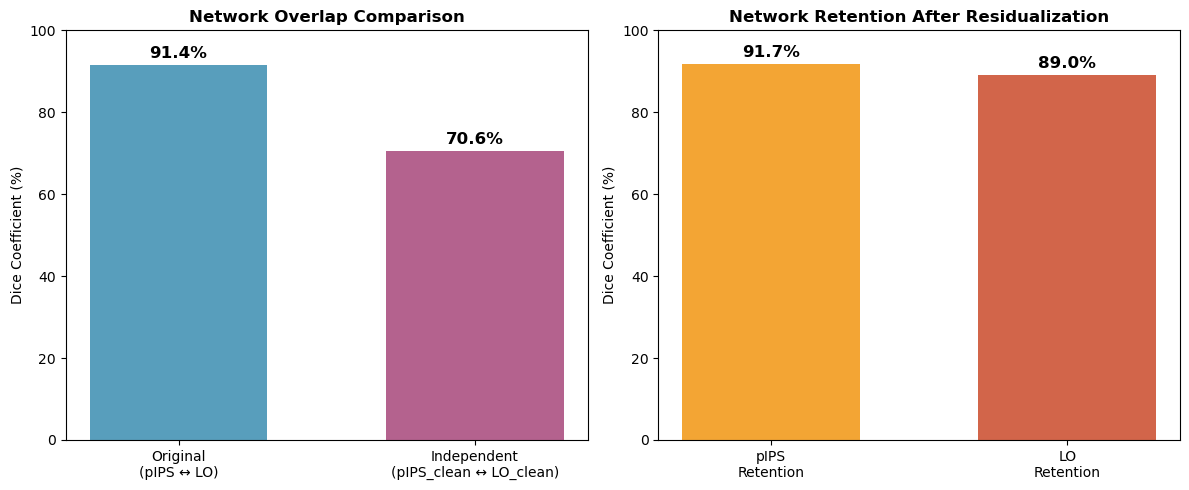

Key Findings:
• Overlap reduction: 91.4% → 70.6% (22.8% relative reduction)
• High retention in both networks: pIPS 91.7%, LO 89.0%
• Subject-level analysis with N=18 subjects


In [15]:
# Cell 6: Create visualizations
print("Creating visualizations...")

# Set up plotting
plt.style.use('default')
sns.set_palette("husl")

# Create output directory
output_dir = f'{results_dir}/network_analysis_plots'
os.makedirs(output_dir, exist_ok=True)

# Figure 1: Overview comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Network overlap comparison
overlap_means = [overlap_results['original']['mean'], overlap_results['independent']['mean']]
overlap_labels = ['Original\n(pIPS ↔ LO)', 'Independent\n(pIPS_clean ↔ LO_clean)']

bars1 = axes[0].bar(overlap_labels, [v*100 for v in overlap_means], 
                   color=['#2E86AB', '#A23B72'], alpha=0.8, width=0.6)
axes[0].set_ylabel('Dice Coefficient (%)')
axes[0].set_title('Network Overlap Comparison', fontweight='bold')
axes[0].set_ylim(0, 100)

# Add value labels on bars
for bar, value in zip(bars1, overlap_means):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                f'{value:.1%}', ha='center', va='bottom', fontweight='bold', fontsize=12)

# Network retention
retention_means = [retention_results['pIPS']['mean'], retention_results['LO']['mean']]
retention_labels = ['pIPS\nRetention', 'LO\nRetention']

bars2 = axes[1].bar(retention_labels, [v*100 for v in retention_means],
                   color=['#F18F01', '#C73E1D'], alpha=0.8, width=0.6)
axes[1].set_ylabel('Dice Coefficient (%)')
axes[1].set_title('Network Retention After Residualization', fontweight='bold')
axes[1].set_ylim(0, 100)

# Add value labels on bars
for bar, value in zip(bars2, retention_means):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                f'{value:.1%}', ha='center', va='bottom', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.savefig(f'{output_dir}/network_overview_bars.png', dpi=300, bbox_inches='tight')
plt.show()

# Print key findings
reduction_abs = overlap_results['original']['mean'] - overlap_results['independent']['mean']
reduction_rel = reduction_abs / overlap_results['original']['mean']

print(f"Key Findings:")
print(f"• Overlap reduction: {overlap_results['original']['mean']:.1%} → {overlap_results['independent']['mean']:.1%} ({reduction_rel:.1%} relative reduction)")
print(f"• High retention in both networks: pIPS {retention_results['pIPS']['mean']:.1%}, LO {retention_results['LO']['mean']:.1%}")
print(f"• Subject-level analysis with N={overlap_results['original']['n']} subjects")